In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ROOT
from pathlib import Path
import mplhep as hep

hep.style.use(hep.style.ATLAS)

import re
import joblib
import logging

# from utils.utils import check_inputpath, check_outputpath, logging_setup

Welcome to JupyROOT 6.28/00


In [18]:
merged_sig = joblib.load("merged_decorated_sig.pkl")
merged_bkg = joblib.load("merged_decorated_bkg.pkl")

In [3]:
sorted(merged_sig.columns)

['AvMu',
 'Channel',
 'CrossSection',
 'DY_jj',
 'Deta_jj',
 'Dphi_jj',
 'Eta_W',
 'Eta_Z',
 'EventNumber',
 'Ht',
 'Jet1E',
 'Jet1Eta',
 'Jet1Phi',
 'Jet1Pt',
 'Jet1Truth',
 'Jet1Y',
 'Jet2E',
 'Jet2Eta',
 'Jet2Phi',
 'Jet2Pt',
 'Jet2Truth',
 'Jet2Y',
 'Jet3E',
 'Jet3Eta',
 'Jet3Phi',
 'Jet3Pt',
 'Jet3Truth',
 'Jet3Y',
 'LTcode',
 'Lep1Charge',
 'Lep1D0Sig',
 'Lep1Eta',
 'Lep1Level',
 'Lep1Phi',
 'Lep1Pt',
 'Lep1WeightW',
 'Lep1WeightZ',
 'Lep2Charge',
 'Lep2D0Sig',
 'Lep2Eta',
 'Lep2Level',
 'Lep2Phi',
 'Lep2Pt',
 'Lep2WeightW',
 'Lep2WeightZ',
 'Lep3Charge',
 'Lep3D0Sig',
 'Lep3Eta',
 'Lep3Level',
 'Lep3Phi',
 'Lep3Pt',
 'Lep3WeightW',
 'Lep3WeightZ',
 'Luminosity',
 'M_123',
 'M_WZ',
 'M_Z',
 'M_jj',
 'Met',
 'Mt_W',
 'Mt_WZ',
 'NBjets',
 'Njets',
 'NormSF',
 'PtBalanceW',
 'PtBalanceZ',
 'Pt_123',
 'Pt_W',
 'Pt_WZ',
 'Pt_Z',
 'Sum3Pt',
 'SumOfWeight',
 'TopCR',
 'TopElCR',
 'TopMuCR',
 'TruthType',
 'WZInclusive',
 'WZInclusiveLoose',
 'WZVBSCR',
 'WZVBSSR',
 'WZqqCR',
 'WZqqSR',


# Branch Name exploration 

For a jet, several attributes are recorded, `E, Eta, Phi, Pt, Truth, Y`.    
For a lepton, they are 
```
 'Lep1Charge',
 'Lep1D0Sig',
 'Lep1Eta',
 'Lep1Level',
 'Lep1Phi',
 'Lep1Pt',
 'Lep1WeightW',
 'Lep1WeightZ',
```

### LTCode
``` cpp 
      if(m_pass_TTVA) m_LTcode = (m_Lep1Level>=122) * 2*2 + (m_Lep2Level>=122) * 2 + (m_Lep3Level>=123);
      else m_LTcode = -1;

``` 

In [5]:
np.unique(merged_sig["LTcode"])

array([7], dtype=int32)

# Pile Up Jet study 

## AvMu distribution

In [6]:
np.unique(merged_sig["Year"])

array([  17,   18, 1516], dtype=int32)

In [7]:
merged_sig_by_year = merged_sig.groupby("Year")

Year: 17, AvMu: 35.942386627197266
Year: 18, AvMu: 35.412864685058594
Year: 1516, AvMu: 22.518798828125


[]

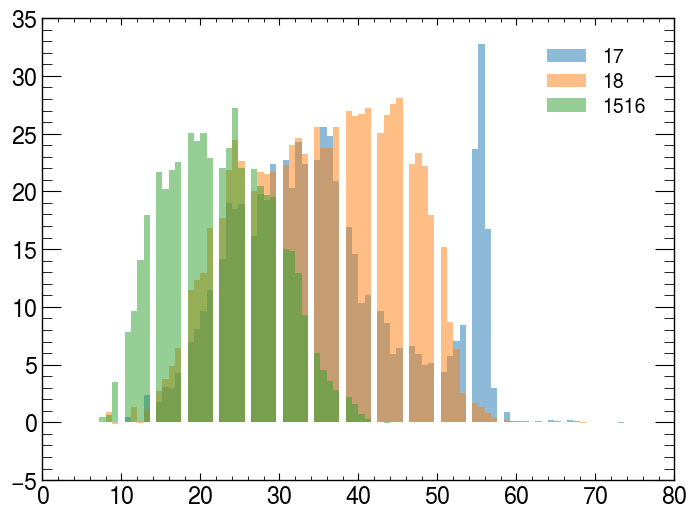

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
# AvMu_max = merged_sig['AvMu'].max()
# AvMu_min = merged_sig['AvMu'].min()
AvMu_max = 80
AvMu_min = 0
bin_edges = np.linspace(AvMu_min, AvMu_max, 101)

for year, year_df in merged_sig_by_year:
    print(f"Year: {year}, AvMu: {np.average(year_df['AvMu'], weights=year_df['WeightNormalized'])}")
    ax.hist(
        year_df["AvMu"],
        weights=year_df["WeightNormalized"],
        bins=bin_edges,
        histtype="stepfilled",
        alpha=0.5,
        label=year,
        density=False,
    )

ax.legend()
ax.plot()

Year: 17, AvMu: 38.45370864868164
Year: 18, AvMu: 37.925384521484375
Year: 1516, AvMu: 23.377843856811523


[]

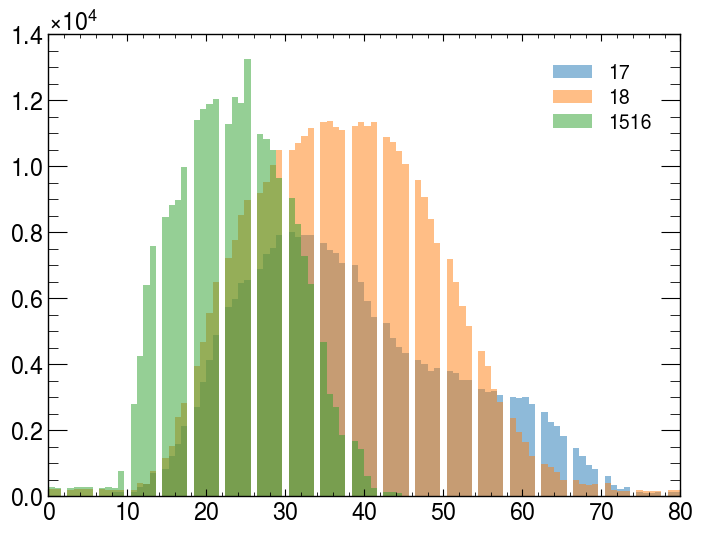

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
# AvMu_max = merged_sig['AvMu'].max()
# AvMu_min = merged_sig['AvMu'].min()
AvMu_max = 80
AvMu_min = 0
bin_edges = np.linspace(AvMu_min, AvMu_max, 101)

for year, year_df in merged_sig_by_year:
    print(f"Year: {year}, AvMu: {year_df['AvMu'].mean()}")
    ax.hist(
        year_df["AvMu"],
        bins=bin_edges,
        histtype="stepfilled",
        alpha=0.5,
        label=year,
        density=False,
    )

ax.legend()
ax.plot()

## Compare with official 
Compared with the ATLAS luminosity   
![mu_2015_2018.png](https://atlas.web.cern.ch/Atlas/GROUPS/DATAPREPARATION/PublicPlots/2018/DataSummary/figs/mu_2015_2018.png)

## Feature studies 

### Jet?Truth

The `Jet?Truth` definition is:  
``` cpp
      m_Jet1Truth = -999;
      if(eventPtr->nGoodJets>0) m_Jet1Truth = (eventPtr->jets.at(eventPtr->nGoodJets-1).truthMatched);
      m_Jet2Truth = -999;
      if(eventPtr->nGoodJets>1) m_Jet2Truth = (eventPtr->jets.at(eventPtr->nGoodJets-2).truthMatched);
      m_Jet3Truth = -999;
      if(eventPtr->nGoodJets>2) m_Jet3Truth = (eventPtr->jets.at(eventPtr->nGoodJets-3).truthMatched);
```  

if `truthMatched` == 1, `Jet1Truth` == 1. 



In [10]:
np.unique(merged_sig["Jet1Truth"], return_counts=True)

(array([0, 1], dtype=int32), array([  6827, 861247]))

In [11]:
np.unique(merged_sig["Jet2Truth"], return_counts=True)

(array([0, 1], dtype=int32), array([ 34874, 833200]))

In [12]:
np.unique(merged_sig["Jet3Truth"], return_counts=True)

(array([-999,    0,    1], dtype=int32), array([637456,  42902, 187716]))

### JetTruth Stats

In [13]:
merged_sig["Event_JetTruth"] = merged_sig["Jet1Truth"] * merged_sig["Jet2Truth"]

In [14]:
unique_values, counts = np.unique(merged_sig["Event_JetTruth"], return_counts=True)

In [15]:
yields = np.bincount(merged_sig["Event_JetTruth"], weights=merged_sig["WeightNormalized"])

In [16]:
stats = pd.DataFrame(columns=unique_values, data=[counts, yields], index=["counts", "yields"]).T

In [17]:
stats["count_frac"] = stats["counts"] / stats["counts"].sum()
stats["yield_frac"] = stats["yields"] / stats["yields"].sum()
print(stats)

     counts       yields  count_frac  yield_frac
0   40766.0   110.497597    0.046961    0.059475
1  827308.0  1747.374165    0.953039    0.940525


In [31]:
mu_bins = np.linspace(0, 100, 11)
merged_sig["AvMu_binidx"] = pd.cut(merged_sig["AvMu"], bins=mu_bins, labels=False)

In [73]:
np.max(merged_sig["AvMu"])

99.5

In [32]:
grouped_merged_sig_byAvMu = merged_sig.groupby("AvMu_binidx")

In [47]:
frac = []
for idx, idx_df in grouped_merged_sig_byAvMu:
    yield_idx = np.bincount(idx_df["Event_JetTruth"], weights=idx_df["WeightNormalized"])
    frac_idx = yield_idx / yield_idx.sum()
    frac.append(frac_idx)
frac = np.array(frac)

In [48]:
frac

array([[ 8.18531034e-04,  9.99181469e-01],
       [ 3.53470997e-02,  9.64652900e-01],
       [ 4.83228971e-02,  9.51677103e-01],
       [ 6.05243790e-02,  9.39475621e-01],
       [ 7.09768695e-02,  9.29023131e-01],
       [ 1.23186208e-01,  8.76813792e-01],
       [ 7.28969123e-02,  9.27103088e-01],
       [ 2.37461999e-01,  7.62538001e-01],
       [-2.26225638e-01,  1.22622564e+00],
       [-1.16526314e-01,  1.11652631e+00]])

In [37]:
import seaborn as sns

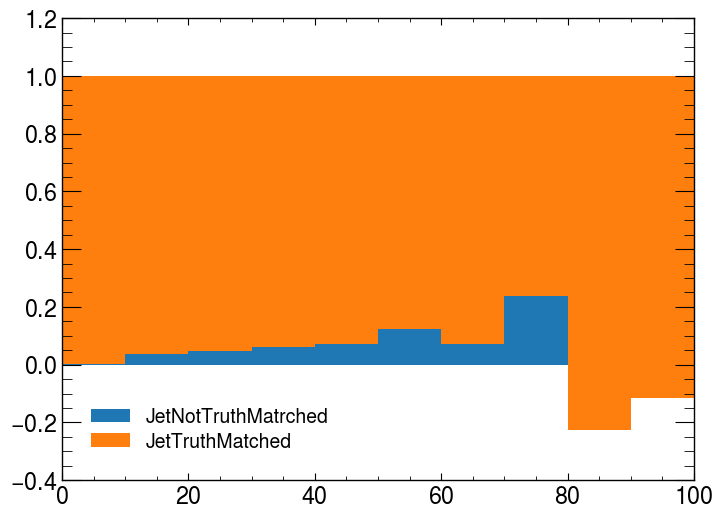

In [53]:
bin_centers = (mu_bins[1:] + mu_bins[:-1]) / 2
bin_width = mu_bins[1] - mu_bins[0]
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(
    bin_centers,
    height=frac[:, 0],
    width=bin_width,
    bottom=np.zeros_like(frac[:, 0]),
    align="center",
    label="JetNotTruthMatrched",
)
plt.bar(
    bin_centers,
    height=frac[:, 1],
    width=bin_width,
    bottom=frac[:, 0],
    align="center",
    label="JetTruthMatched",
)
plt.legend()

### TruthType

The `TruthType` definition is:
``` cpp
      m_TruthType = -1;
      if(eventPtr->isMC){
        m_TruthType = eventPtr->Lep1.truthMatched * 2*2 + eventPtr->Lep2.truthMatched * 2 + eventPtr->Lep3.truthMatched;
      }

```

It's similar to the Linux priviledge scheme, 4 + 2 + 1 = 7  
```
1: Only the 3rd Lep is truth Matched   
2: Only the 2nd Lep is truth Matched   
4: Only the 1st Lep is truth Matched   
5: the 1st and the 3rd Leps are truth Matched  
6: the 1st and the 2nd Leps are truth Matched   
7: all three leptons are truth Matched     
```

# peak study 

In [37]:
feature = "ZetaLep"

In [38]:
feature_min = merged_sig[feature].min()
feature_max = merged_sig[feature].max()

feature_bins = np.linspace(feature_min, feature_max, 101)
sig_bin_contents, sig_bin_edges = np.histogram(
    merged_sig[feature],
    bins=feature_bins,
    density=True,
    weights=merged_sig["WeightNormalized"],
)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x30c171660>, errorbar=None, legend_artist=None)]

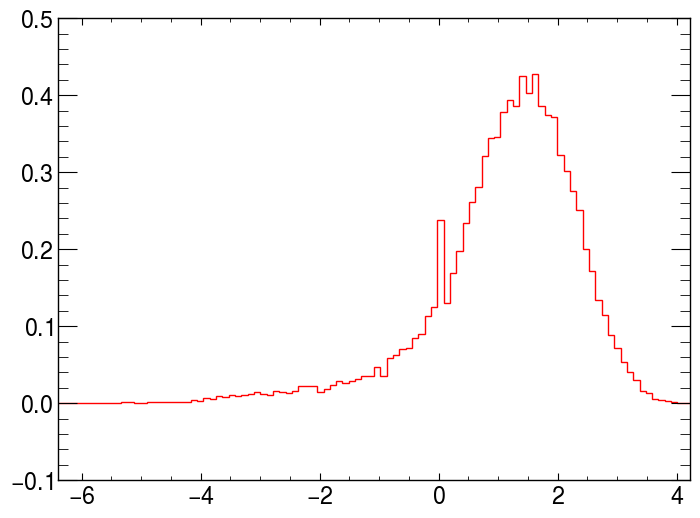

In [39]:
fig, ax = plt.subplots()
ax.set_xlim(feature_min, feature_max)
hep.histplot(sig_bin_contents, sig_bin_edges, label="Signal", ax=ax, color="red")

In [40]:
np.where(sig_bin_edges >= 0)[0]

array([ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100])

In [41]:
idx = 60

In [42]:
sig_bin_contents[59]

0.12469018889565096

In [43]:
sig_bin_contents[60]

0.23726423034763156

In [44]:
sig_bin_edges[61]

0.08499898433685349

In [45]:
sel = merged_sig.loc[
    (merged_sig["ZetaLep"] >= sig_bin_edges[idx]) & (merged_sig["ZetaLep"] <= sig_bin_edges[idx + 1])
]

In [46]:
sel_lastbin = merged_sig.loc[
    (merged_sig["ZetaLep"] >= sig_bin_edges[idx - 1]) & (merged_sig["ZetaLep"] <= sig_bin_edges[idx])
]
sel_nextbin = merged_sig.loc[
    (merged_sig["ZetaLep"] >= sig_bin_edges[idx + 1]) & (merged_sig["ZetaLep"] <= sig_bin_edges[idx + 2])
]

In [47]:
len(sel_lastbin)

11971

In [48]:
len(sel_nextbin)

13564

In [49]:
sel["ZetaLep"]

126       0.004721
186       0.006437
200       0.057792
216       0.017306
347      -0.006668
            ...   
136177    0.049635
136298    0.004044
136333   -0.010103
136352   -0.005666
136373    0.016417
Name: ZetaLep, Length: 19465, dtype: float32

(array([142., 175., 175., 185., 181., 185., 228., 196., 203., 210., 232.,
        237., 258., 226., 268., 271., 280., 287., 323., 333., 332., 336.,
        340., 357., 358., 346., 373., 328., 302., 334., 337., 341., 334.,
        309., 299., 303., 274., 254., 253., 246., 218., 210., 251., 211.,
        198., 187., 195., 172., 178., 139., 162., 141., 165., 152., 144.,
        153., 156., 157., 133., 156., 136., 133., 133., 127., 108., 122.,
        145., 111., 118., 109., 123., 127., 137., 135., 136., 146., 118.,
        123., 107., 148., 120., 124., 125., 116., 115., 120., 124., 141.,
        138., 126., 112., 116., 115., 131., 135., 135., 113., 113., 126.,
        149.]),
 array([-2.11955309e-02, -2.01336462e-02, -1.90717634e-02, -1.80098787e-02,
        -1.69479940e-02, -1.58861093e-02, -1.48242256e-02, -1.37623418e-02,
        -1.27004571e-02, -1.16385734e-02, -1.05766896e-02, -9.51480493e-03,
        -8.45292117e-03, -7.39103695e-03, -6.32915273e-03, -5.26726851e-03,
        -4.205

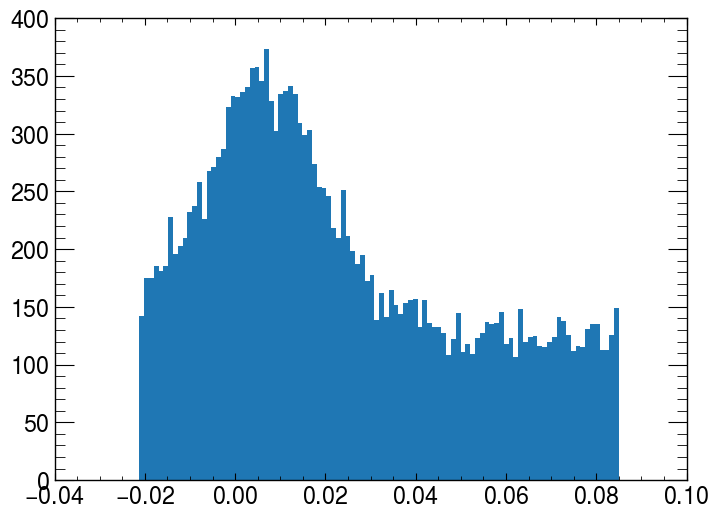

In [50]:
plt.hist(sel["ZetaLep"], bins=100)

In [51]:
len(sel) / len(merged_sig)

0.022423203551770934

In [52]:
len(sel)

19465

In [53]:
len(merged_sig)

868074

In [54]:
bin_width = sig_bin_edges[1] - sig_bin_edges[0]

In [55]:
np.sum(sel["WeightNormalized"]) / merged_sig["WeightNormalized"].sum() / bin_width

0.23726425442214816

In [56]:
np.max(sel["WeightNormalized"])

0.17283636

In [57]:
np.min(sel["WeightNormalized"])

-0.17152566

``` cpp
     if(var=="ZetaLep"){
       double deltaEtaMinus = min((eventPtr->Lep3.p4).Eta(),min((eventPtr->Lep1.p4).Eta(),(eventPtr->Lep2.p4).Eta())) - min((eventPtr->jets.at(eventPtr->nGoodJets-1).p4).Eta(),(eventPtr->jets.at(eventPtr->nGoodJets-2).p4).Eta());
       double deltaEtaPlus = max((eventPtr->jets.at(eventPtr->nGoodJets-1).p4).Eta(),(eventPtr->jets.at(eventPtr->nGoodJets-2).p4).Eta()) - max((eventPtr->Lep3.p4).Eta(),max((eventPtr->Lep1.p4).Eta(),(eventPtr->Lep2.p4).Eta()));
       returnValue = min(deltaEtaMinus,deltaEtaPlus);
     }

```

In [ ]:
merged_sig_by_MC = merged_sig.groupby("isMC")
for MC_idx, MC_df in merged_sig_by_MC:
    sig_bin_contents, sig_bin_edges = np.histogram(
        merged_sig[feature],
        bins=feature_bins,
        density=True,
        weights=merged_sig["WeightNormalized"],
    )

    fig, ax = plt.subplots()
    ax.set_xlim(feature_min, feature_max)
    hep.histplot(
        sig_bin_contents,
        sig_bin_edges,
        label=f"{MC_idx} Signal",
        ax=ax,
        color="red",
    )

    ax.legend()

# Calculate Zeta by myself 

In [ ]:
delta_min = merged_sig[["Lep1Eta", "Lep2Eta", "Lep3Eta"]].min(axis=1) - merged_sig[
    ["Jet1Eta", "Jet2Eta"]
].min(axis=1)
delta_max = merged_sig[["Jet1Eta", "Jet2Eta"]].max(axis=1) - merged_sig[
    ["Lep1Eta", "Lep2Eta", "Lep3Eta"]
].max(axis=1)
merged_sig["Zeta_hr"] = pd.concat([delta_min, delta_max], axis=1, keys=["delta_min", "delta_max"]).min(
    axis=1
)

In [ ]:
np.allclose(merged_sig["ZetaLep"], merged_sig["Zeta_hr"])

In [ ]:
sig_m450 = merged_sig_by_MC.get_group(450770)

In [ ]:
delta_min = sig_m450[["Lep1Eta", "Lep2Eta", "Lep3Eta"]].min(axis=1) - sig_m450[["Jet1Eta", "Jet2Eta"]].min(
    axis=1
)
delta_max = sig_m450[["Jet1Eta", "Jet2Eta"]].max(axis=1) - sig_m450[["Lep1Eta", "Lep2Eta", "Lep3Eta"]].max(
    axis=1
)

In [ ]:
sig_m450["Zeta_hr"] = pd.concat([delta_min, delta_max], axis=1, keys=["delta_min", "delta_max"]).min(axis=1)

In [ ]:
sig_m450[["Lep1Eta", "Lep2Eta", "Lep3Eta"]]

In [55]:
merged_sig.columns

Index(['Yields', 'isMC', 'Channel', 'Year', 'NormSF', 'WeightSign',
       'WeightNormalized', 'Weight', 'M_WZ', 'M_123', 'Mt_WZ', 'M_Z', 'Mt_W',
       'Met', 'Njets', 'NBjets', 'SumOfWeight', 'Luminosity', 'CrossSection',
       'WZInclusiveLoose', 'WZInclusive', 'WZqqSR', 'WZqqCR', 'WZVBSSR',
       'WZVBSCR', 'ZfakeElCR', 'ZfakeMuCR', 'ZfakeCR', 'TopElCR', 'TopMuCR',
       'TopCR', 'ZZCR', 'EventNumber', 'AvMu', 'M_jj', 'Deta_jj', 'DY_jj',
       'Dphi_jj', 'PtBalanceZ', 'PtBalanceW', 'ZetaLep', 'Sum3Pt', 'Pt_123',
       'Pt_WZ', 'Pt_W', 'Pt_Z', 'Eta_W', 'Eta_Z', 'LTcode', 'TruthType',
       'genMass', 'Jet1Pt', 'Jet2Pt', 'Jet3Pt', 'Jet1Eta', 'Jet2Eta',
       'Jet3Eta', 'Jet1Phi', 'Jet2Phi', 'Jet3Phi', 'Jet1E', 'Jet2E', 'Jet3E',
       'Jet1Y', 'Jet2Y', 'Jet3Y', 'Jet1Truth', 'Jet2Truth', 'Jet3Truth',
       'Lep1Pt', 'Lep2Pt', 'Lep3Pt', 'Lep1Eta', 'Lep2Eta', 'Lep3Eta',
       'Lep1Phi', 'Lep2Phi', 'Lep3Phi', 'Lep1Charge', 'Lep2Charge',
       'Lep3Charge', 'Lep1D0Sig', 'Lep2D0S

In [56]:
merged_sig["Lep1R"] = np.sqrt(merged_sig["Lep1Eta"] ** 2 + merged_sig["Lep1Phi"] ** 2)
merged_sig["Lep2R"] = np.sqrt(merged_sig["Lep2Eta"] ** 2 + merged_sig["Lep2Phi"] ** 2)
merged_sig["Lep3R"] = np.sqrt(merged_sig["Lep3Eta"] ** 2 + merged_sig["Lep3Phi"] ** 2)

merged_sig["Jet1R"] = np.sqrt(merged_sig["Jet1Eta"] ** 2 + merged_sig["Jet1Phi"] ** 2)
merged_sig["Jet2R"] = np.sqrt(merged_sig["Jet2Eta"] ** 2 + merged_sig["Jet2Phi"] ** 2)

In [57]:
merged_sig["dR_Lep1_Jet1"] = np.abs(merged_sig["Lep1R"] - merged_sig["Jet1R"])
merged_sig["dR_Lep1_Jet2"] = np.abs(merged_sig["Lep1R"] - merged_sig["Jet2R"])
merged_sig["dR_Lep2_Jet1"] = np.abs(merged_sig["Lep2R"] - merged_sig["Jet1R"])
merged_sig["dR_Lep2_Jet2"] = np.abs(merged_sig["Lep2R"] - merged_sig["Jet2R"])
merged_sig["dR_Lep3_Jet1"] = np.abs(merged_sig["Lep3R"] - merged_sig["Jet1R"])
merged_sig["dR_Lep3_Jet2"] = np.abs(merged_sig["Lep3R"] - merged_sig["Jet2R"])

In [59]:
merged_sig[
    [
        "dR_Lep1_Jet1",
        "dR_Lep1_Jet2",
        "dR_Lep2_Jet1",
        "dR_Lep2_Jet2",
        "dR_Lep3_Jet1",
        "dR_Lep3_Jet2",
    ]
]

,dR_Lep1_Jet1,dR_Lep1_Jet2,dR_Lep2_Jet1,dR_Lep2_Jet2,dR_Lep3_Jet1,dR_Lep3_Jet2
3,2.729578,0.401066,3.180768,0.852255,1.972422,0.356090
11,2.064535,1.158581,0.334550,0.571404,2.667006,1.761051
14,2.569289,3.618850,0.904761,1.954321,1.237123,2.286684
16,2.732799,0.010870,3.619586,0.897657,1.685784,1.036144
22,0.837969,1.102176,1.728708,1.992915,1.633997,1.898204
...,...,...,...,...,...,...
136522,2.266838,2.749968,1.800798,2.283928,1.275032,1.758162
136524,0.554781,0.910646,0.786864,0.678563,1.980840,0.515413
136525,4.088717,3.461045,4.556480,3.928808,1.694736,1.067064
136527,3.164472,1.839000,3.408416,2.082944,2.324828,0.999356


In [61]:
merged_sig["min_dR"] = np.min(
    merged_sig[
        [
            "dR_Lep1_Jet1",
            "dR_Lep1_Jet2",
            "dR_Lep2_Jet1",
            "dR_Lep2_Jet2",
            "dR_Lep3_Jet1",
            "dR_Lep3_Jet2",
        ]
    ],
    axis=1,
)

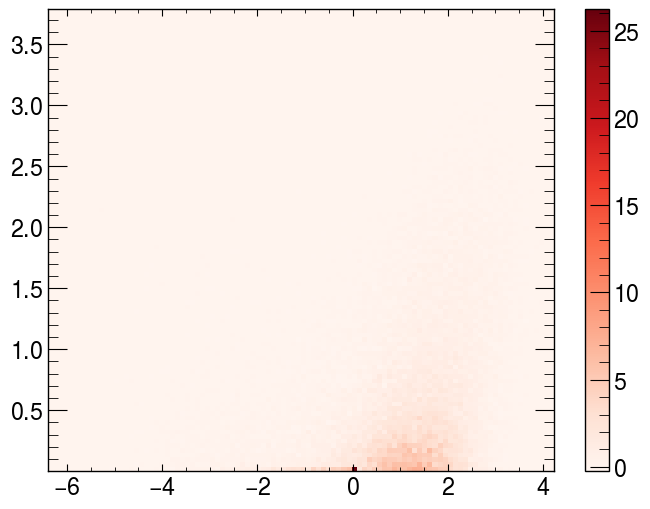

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.hist2d(
    merged_sig["ZetaLep"],
    merged_sig["min_dR"],
    bins=100,
    weights=merged_sig["WeightNormalized"],
    cmap=plt.cm.Reds,
)
plt.colorbar()
plt.show()

# Their NN distribution

In [19]:
df_signal = merged_sig
df_bkg = merged_bkg

In [8]:
df_signal_grouped = df_signal.groupby("file_identifer")

In [26]:
len(list(df_signal_grouped.groups.keys()))

20

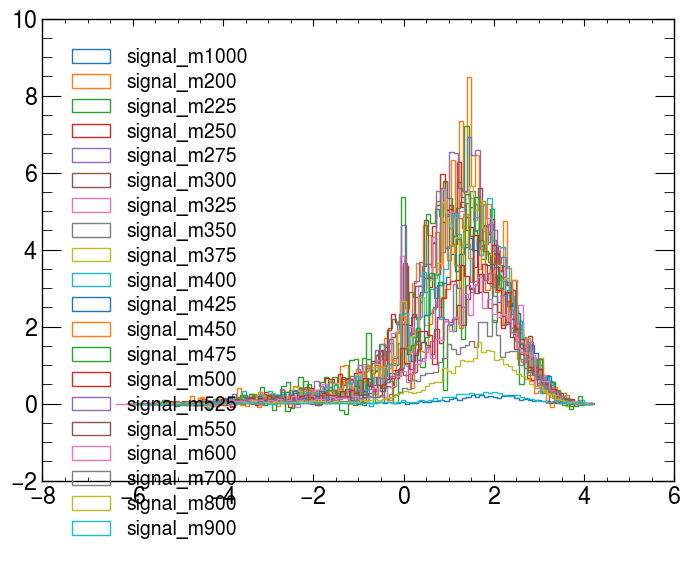

In [27]:
# draw pSignal_GM distribution for each file
for file_identifier, df in df_signal_grouped:
    plt.hist(
        df["ZetaLep"],
        bins=100,
        weights=df["WeightNormalized"],
        label=file_identifier,
        histtype="step",
    )
plt.legend()

In [ ]:
# draw pSignal_GM distribution for each file
for file_identifier, df in df_signal_grouped:
    plt.hist(
        df["pSignal_GM"],
        bins=100,
        weights=df["WeightNormalized"],
        label=file_identifier,
        histtype="step",
    )
plt.legend()

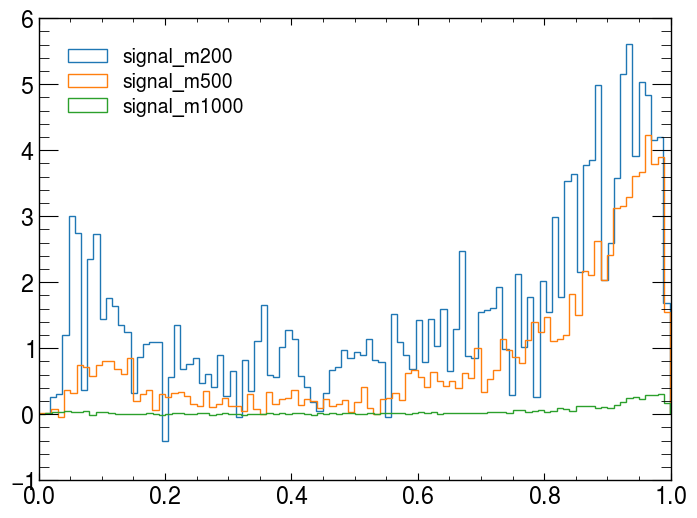

In [16]:
# only draw several mass points, 200, 500, 1000
fig, ax = plt.subplots(figsize=(8, 6))

for mass in ["200", "500", "1000"]:
    df = df_signal_grouped.get_group(f"signal_m{mass}")
    plt.hist(
        df["pSignal_GM"],
        bins=100,
        weights=df["WeightNormalized"],
        label=f"signal_m{mass}",
        histtype="step",
    )
plt.legend()

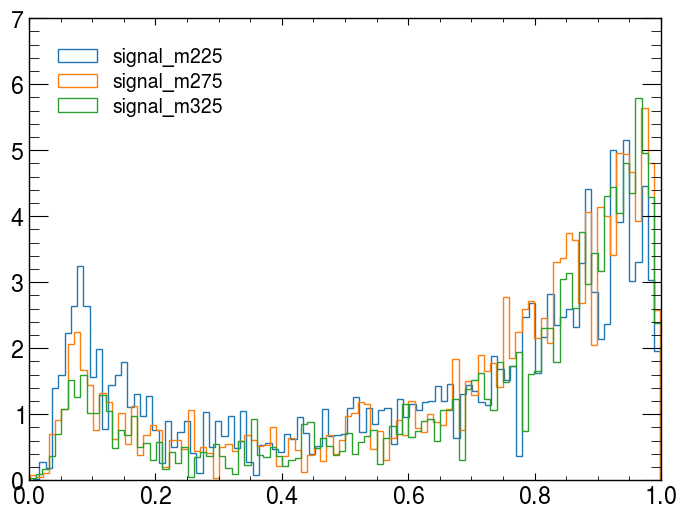

In [29]:
# only draw several mass points, 200, 500, 1000
fig, ax = plt.subplots(figsize=(8, 6))

for mass in ["225", "275", "325"]:
    df = df_signal_grouped.get_group(f"signal_m{mass}")
    plt.hist(
        df["pSignal_GM"],
        bins=100,
        weights=df["WeightNormalized"],
        label=f"signal_m{mass}",
        histtype="step",
    )
plt.legend()

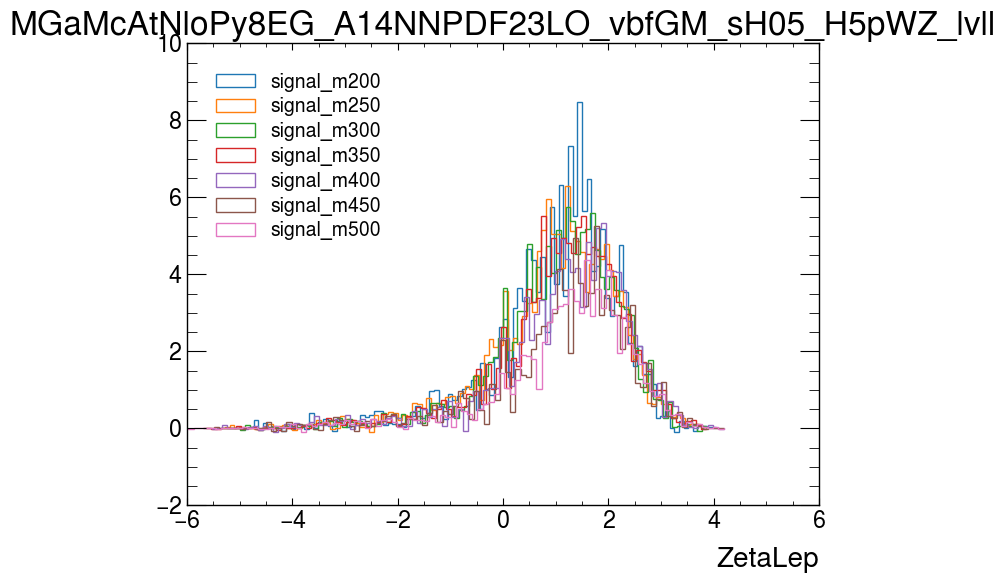

In [61]:
# only draw several mass points, 200, 500, 1000
fig, ax = plt.subplots(figsize=(8, 6))

for mass in ["200", "250", "300", "350", "400", "450", "500"]:
    df = df_signal_grouped.get_group(f"signal_m{mass}")
    plt.hist(
        df["ZetaLep"],
        bins=100,
        weights=df["WeightNormalized"],
        label=f"signal_m{mass}",
        histtype="step",
    )
plt.title("MGaMcAtNloPy8EG_A14NNPDF23LO_vbfGM_sH05_H5pWZ_lvll")
plt.xlabel("ZetaLep")
plt.legend()

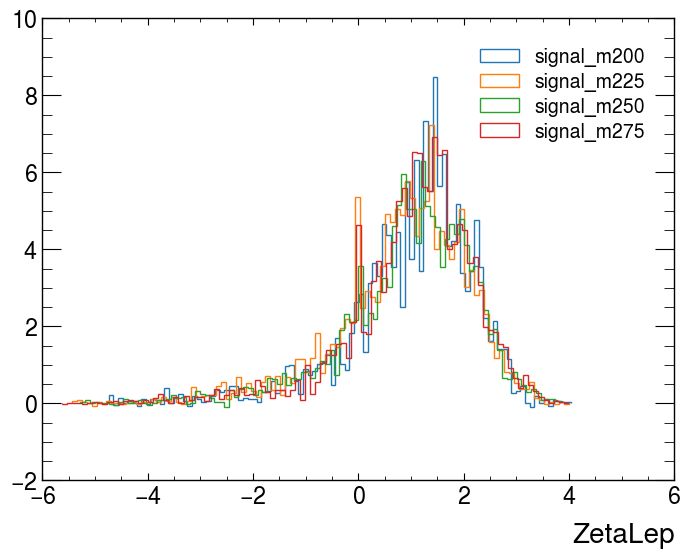

In [58]:
# only draw several mass points, 200, 500, 1000
fig, ax = plt.subplots(figsize=(8, 6))

for mass in ["200", "225", "250", "275"]:
    df = df_signal_grouped.get_group(f"signal_m{mass}")
    plt.hist(
        df["ZetaLep"],
        bins=100,
        weights=df["WeightNormalized"],
        label=f"signal_m{mass}",
        histtype="step",
    )
plt.xlabel("ZetaLep")
plt.legend()

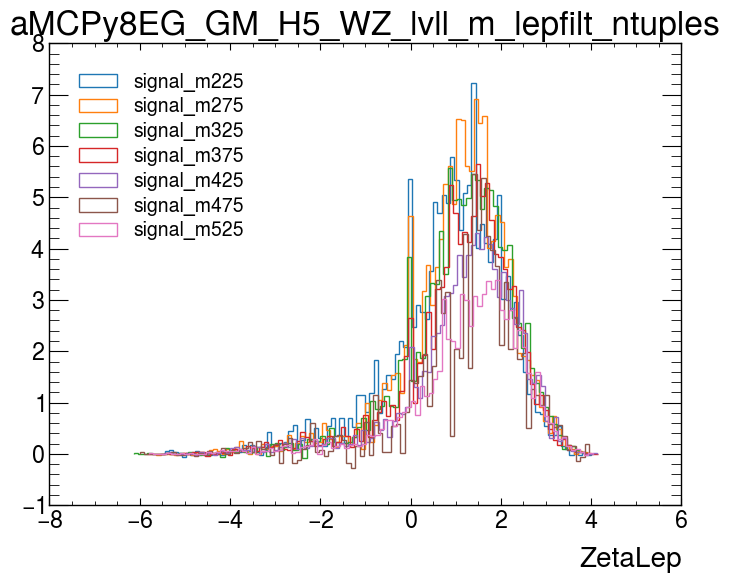

In [63]:
# only draw several mass points, 200, 500, 1000
fig, ax = plt.subplots(figsize=(8, 6))

for mass in ["225", "275", "325", "375", "425", "475", "525"]:
    df = df_signal_grouped.get_group(f"signal_m{mass}")
    plt.hist(
        df["ZetaLep"],
        bins=100,
        weights=df["WeightNormalized"],
        label=f"signal_m{mass}",
        histtype="step",
    )

plt.title("aMCPy8EG_GM_H5_WZ_lvll_m_lepfilt_ntuples")
plt.xlabel("ZetaLep")
plt.legend()

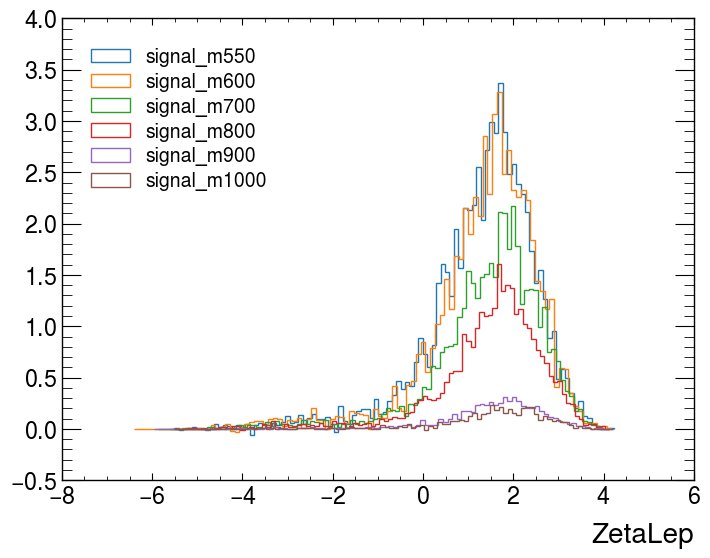

In [36]:
# only draw several mass points, 200, 500, 1000
fig, ax = plt.subplots(figsize=(8, 6))

for mass in ["550", "600", "700", "800", "900", "1000"]:
    df = df_signal_grouped.get_group(f"signal_m{mass}")
    plt.hist(
        df["ZetaLep"],
        bins=100,
        weights=df["WeightNormalized"],
        label=f"signal_m{mass}",
        histtype="step",
    )
plt.xlabel("ZetaLep")
plt.legend()